# Last FM hometask <br>
https://www.kaggle.com/ravichaubey1506/lastfm <br>
1. Выбрать данные по странам своей группы (совместно): <br>
    3530203_70101: Germany, Netherlands <br>
    3530203_70102: Belarus, Ukraine, Poland, Russian Federation<br>
    3530903_70301: Sweden, Finland, Norway, Denmark, Iceland<br>
    3530903_70302: Spain, Portugal, France, Italy, Belgium<br>
    
2. Попытаться найти полезные с точки зрения продвижения групп (или еще чего-нибудь) и нетривиальные правила, используя алгоритмы Apriori, FPGrowth, FPMax и всевозможные метрики. Хотя бы 5 правил.
3. Вывести эти правила в отдельных ячейках. 
4. Подумать, как можно было бы использовать полученные правила.

In [36]:
import pandas as pd
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth, fpmax

pd.options.display.max_rows = 1000

In [2]:
data = pd.read_csv("lastfm.csv")
data.head()

,user,artist,sex,country
0,1,red hot chili peppers,f,Germany
1,1,the black dahlia murder,f,Germany
2,1,goldfrapp,f,Germany
3,1,dropkick murphys,f,Germany
4,1,le tigre,f,Germany


In [3]:
#pip install mlxtend

### Скорректируем данные

In [4]:
data['country'] = data['country'].str.strip(' ')
data['country'] = data['country'].str.capitalize()

In [5]:
data['artist'] = data['artist'].str.strip(' ')
data['artist'] = data['artist'].str.lower()

### Возьмем только Germany, Netherlands

In [6]:
data = data[data['country'].isin(['Germany','Netherlands'])]
# Netherlands Antilles - don't include

In [7]:
data['country'].value_counts()

Germany        24251
Netherlands     9673
Name: country, dtype: int64

### Проверим пустые и неизвестные значения

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33924 entries, 0 to 289615
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user     33924 non-null  int64 
 1   artist   33924 non-null  object
 2   sex      33924 non-null  object
 3   country  33924 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.3+ MB


In [9]:
data['sex'].unique()

array(['f', 'm'], dtype=object)

In [10]:
data['country'].unique()

array(['Germany', 'Netherlands'], dtype=object)

In [11]:
for i in data['artist'].unique():
    print(i)

red hot chili peppers
the black dahlia murder
goldfrapp
dropkick murphys
le tigre
schandmaul
edguy
jack johnson
eluveitie
the killers
judas priest
rob zombie
john mayer
the who
guano apes
the rolling stones
jamiroquai
tori amos
jazzanova
radiohead
st. germain
marvin gaye
moloko
nightmares on wax
the verve
nick cave and the bad seeds
de-phazz
blonde redhead
diana krall
massive attack
cocorosie
dave matthews band
the smiths
jamie cullum
joy division
porcupine tree
thievery corporation
róisín murphy
death cab for cutie
tegan and sara
kimya dawson
die ärzte
coldplay
the kooks
the fray
mando diao
farin urlaub
a fine frenzy
die toten hosen
deichkind
razorlight
clueso
evanescence
linkin park
seeed
three days grace
cute is what we aim for
incubus
buena vista social club
counting crows
paolo nutini
the strokes
keane
belle and sebastian
adam green
story of the year
paramore
nouvelle vague
ok go
foo fighters
soundtrack
groove coverage
avril lavigne
the rasmus
him
nightwish
as i lay dying
in extre

In [12]:
data[(data['artist'] == '[unknown]')].count()

user       95
artist     95
sex        95
country    95
dtype: int64

In [13]:
data = data[(data['artist'] != '[unknown]')]

In [14]:
data[(data['artist'] == '[unknown]')].count()

user       0
artist     0
sex        0
country    0
dtype: int64

### Проверим данные по артистам

In [15]:
data['artist'].value_counts().describe()

count    1001.000000
mean       33.795205
std        35.136747
min         1.000000
25%        13.000000
50%        22.000000
75%        41.000000
max       296.000000
Name: artist, dtype: float64

In [16]:
### Кажется, что артисты с малым количеством слушателей не явлются релевантными
### при поиске паттернов. Возьмем группы со значением больше 10

In [17]:
data = data.groupby(['artist']).filter(lambda x: x['artist'].count() > 10.)

In [18]:
data['artist'].value_counts().describe()

count    826.000000
mean      39.480630
std       36.195868
min       11.000000
25%       17.000000
50%       27.000000
75%       47.000000
max      296.000000
Name: artist, dtype: float64

In [19]:
### Проверим данные по пользователям

In [20]:
data['user'].value_counts().describe()

count    1722.000000
mean       18.937863
std        10.127036
min         1.000000
25%        11.000000
50%        19.000000
75%        26.000000
max        53.000000
Name: user, dtype: float64

In [21]:
### Кажется, что пользователи с малым количеством групп не явлются релевантными
### при поиске паттернов. Возьмем пользователей со значением больше 10

In [22]:
data = data.groupby(['user']).filter(lambda x: x['user'].count() >= 10.)

In [23]:
data['user'].value_counts().describe()

count    1350.000000
mean       22.606667
std         8.172716
min        10.000000
25%        16.000000
50%        22.000000
75%        29.000000
max        53.000000
Name: user, dtype: float64

In [24]:
data.head()

,user,artist,sex,country
0,1,red hot chili peppers,f,Germany
1,1,the black dahlia murder,f,Germany
2,1,goldfrapp,f,Germany
3,1,dropkick murphys,f,Germany
4,1,le tigre,f,Germany


# Let's find rules

## By user in two countries

In [25]:
data_by_user = data.groupby(['user', 'country', 'sex'])['artist'].apply(lambda x: ','.join(x).lower().strip()).reset_index()
data_by_user

,user,country,sex,artist
0,1,Germany,f,"red hot chili peppers,the black dahlia murder,..."
1,31,Netherlands,f,"jamiroquai,tori amos,jazzanova,radiohead,st. g..."
2,33,Germany,f,"death cab for cutie,tegan and sara,kimya dawso..."
3,51,Germany,f,"kate nash,arctic monkeys,lykke li,adele,tegan ..."
4,62,Germany,f,"beatsteaks,clueso,the kooks,die ärzte,plain wh..."
...,...,...,...,...
1345,19642,Germany,m,"fear factory,hypocrisy,the velvet underground,..."
1346,19662,Germany,m,"blind guardian,in extremo,subway to sally,finn..."
1347,19681,Netherlands,m,"the strokes,muse,led zeppelin,snow patrol,radi..."
1348,19685,Netherlands,m,"philip glass,rammstein,pink floyd,moby,blank &..."


In [26]:
#dummy encoding
dummy_data_by_user = data_by_user['artist'].str.get_dummies(',')
dummy_data_by_user = pd.concat([data_by_user, dummy_data_by_user], axis = 1)
dummy_data_by_user

,user,country,sex,artist,...and you will know us by the trail of dead,2pac,3 doors down,30 seconds to mars,36 crazyfists,44,...,venetian snares,vnv nation,volbeat,weezer,within temptation,wolfgang amadeus mozart,yann tiersen,yeah yeah yeahs,yellowcard,zero 7
0,1,Germany,f,"red hot chili peppers,the black dahlia murder,...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,31,Netherlands,f,"jamiroquai,tori amos,jazzanova,radiohead,st. g...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,33,Germany,f,"death cab for cutie,tegan and sara,kimya dawso...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,51,Germany,f,"kate nash,arctic monkeys,lykke li,adele,tegan ...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,62,Germany,f,"beatsteaks,clueso,the kooks,die ärzte,plain wh...",0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1345,19642,Germany,m,"fear factory,hypocrisy,the velvet underground,...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1346,19662,Germany,m,"blind guardian,in extremo,subway to sally,finn...",0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1347,19681,Netherlands,m,"the strokes,muse,led zeppelin,snow patrol,radi...",0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1348,19685,Netherlands,m,"philip glass,rammstein,pink floyd,moby,blank &...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
#Добавим 2 столбца, которые будут описывать пол пользователя
dummy_data_by_user['male'] = dummy_data_by_user['sex'].apply(lambda x: 1 if x == 'm' else 0);
dummy_data_by_user['female'] = dummy_data_by_user['sex'].apply(lambda x: 1 if x == 'f' else 0);
dummy_data_by_user

,user,country,sex,artist,...and you will know us by the trail of dead,2pac,3 doors down,30 seconds to mars,36 crazyfists,44,...,volbeat,weezer,within temptation,wolfgang amadeus mozart,yann tiersen,yeah yeah yeahs,yellowcard,zero 7,male,female
0,1,Germany,f,"red hot chili peppers,the black dahlia murder,...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,31,Netherlands,f,"jamiroquai,tori amos,jazzanova,radiohead,st. g...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,33,Germany,f,"death cab for cutie,tegan and sara,kimya dawso...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,51,Germany,f,"kate nash,arctic monkeys,lykke li,adele,tegan ...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,62,Germany,f,"beatsteaks,clueso,the kooks,die ärzte,plain wh...",0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1345,19642,Germany,m,"fear factory,hypocrisy,the velvet underground,...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1346,19662,Germany,m,"blind guardian,in extremo,subway to sally,finn...",0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1347,19681,Netherlands,m,"the strokes,muse,led zeppelin,snow patrol,radi...",0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
1348,19685,Netherlands,m,"philip glass,rammstein,pink floyd,moby,blank &...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [65]:
frequent_itemsets_user4 = fpgrowth(dummy_data_by_user.drop(columns=['user','country', 'sex', 'artist']), 
                            min_support=0.012, use_colnames=True)

frequent_itemsets_user4

,support,itemsets
0,0.247407,(female)
1,0.188889,(red hot chili peppers)
2,0.133333,(the killers)
3,0.120000,(jack johnson)
4,0.059259,(the rolling stones)
...,...,...
4176,0.013333,"(male, taking back sunday)"
4177,0.019259,"(male, ladytron)"
4178,0.012593,"(male, tv on the radio)"
4179,0.012593,"(male, the dillinger escape plan)"


In [66]:
#Замечаем, что rammstein можно рекомендовать не только парням, но и девушками при определнных условиях
rules_by_user = association_rules(frequent_itemsets_user4, metric="confidence", min_threshold=0.55)
rules_by_user[ 
    ((rules_by_user['antecedents'] >= {'female'}) | (rules_by_user['antecedents'] >= {'male'})) &
    (rules_by_user['consequents'] >= {'rammstein'})
]
       

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
435,"(male, in flames, system of a down)",(rammstein),0.022963,0.152593,0.014815,0.645161,4.227999,0.011311,2.388148
484,"(bullet for my valentine, male, system of a down)",(rammstein),0.025926,0.152593,0.017037,0.657143,4.306519,0.013081,2.471605
545,"(male, system of a down, slipknot)",(rammstein),0.024444,0.152593,0.014815,0.606061,3.971756,0.011085,2.151111
691,"(female, subway to sally)",(rammstein),0.021481,0.152593,0.012593,0.586207,3.841647,0.009315,2.047901
1333,"(in extremo, male, system of a down)",(rammstein),0.018519,0.152593,0.012593,0.680000,4.456311,0.009767,2.648148


<AxesSubplot:xlabel='sex', ylabel='count'>

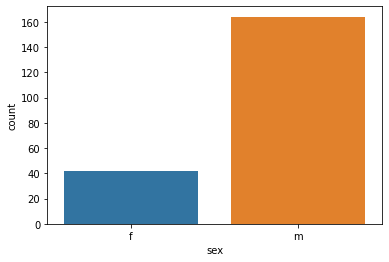

In [67]:
#Примерно 20% слушателей rammstein - это девушки, поэтому делая рекомендации основываясь на поле человека, можно более качественно порекомендовать новых артистов
sns.countplot(x='sex', data=data[(data['artist'] == 'rammstein')])